In [2]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
from matplotlib import tri

#matplotlib_inline.backend_inline.set_matplotlib_formats('svg') # higher quality
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

variables

In [4]:
# https://en.wikipedia.org/wiki/Glycerol
T = 20 # C
rho = 1264.02 # kg/m^3  
nu =  0.0018 # m^2/s
mu = 2.275236 # kg/(m*s)
g = 9.8066 # m/s^2
pi = np.pi

v_infs = defaultdict(float)

reynolds = [0.1, 1, 10, 100]
for i, re in enumerate(reynolds):
    v_inf = round(re*nu/(2*0.01),3)
    print(f"Re = {re}, v_inf = {v_inf}")
    v_infs[re] = v_inf

Re = 0.1, v_inf = 0.009
Re = 1, v_inf = 0.09
Re = 10, v_inf = 0.9
Re = 100, v_inf = 9.0


In [5]:
# Domain [-1,1] x [-1,1]
H = 2.0 # m
W = 2.0 # m
rectangle_center = (0.0, 0.0) # (m, m)

# Sphere / Disk
circle_radius = 0.01 # m
circle_center = (0.0, 0.0) # (m, m)

functions

In [7]:
def get_data(loc, Re):
    flow_data = np.loadtxt(loc+"/flow_data.txt", comments="%").T
    r = flow_data[0] # r-component (cylindrical): m
    z = flow_data[1] # z-component (cylindrical): m 
    R = flow_data[2] # r-component (spherical): m
    theta = flow_data[3] # theta-component (spherical): radians
    v_r_comsol = flow_data[4] # velocity r-component (spherical): m/s
    v_theta_comsol = flow_data[5] # velocity theta-component (spherical): m/s
    u_r_comsol = flow_data[6] # velocity r-component (cylindrical): m/s
    u_z_comsol = flow_data[7] # velocity z-component (cylindricial): m/s
    U = flow_data[8] # velocity magnitude (cylindrical): m/s
    p_comsol = flow_data[9] # pressure (cylindrical): Pa
    v_inf = v_infs[Re] # far-field velocity: m/s

    drag_data = np.loadtxt(loc+"/drag_data.txt", comments="%").T
    F_t_comsol = drag_data[0] # tangential force: N
    F_n_comsol = drag_data[1] # normal force: N

    return r, z, R, theta, v_r_comsol, v_theta_comsol, u_r_comsol, u_z_comsol, U, p_comsol, v_inf, Re, F_t_comsol, F_n_comsol

In [8]:
def get_full(r, z, u_r_comsol, u_z_comsol, p_comsol, u_r_true=None, u_z_true=None, p_true=None):
    non_zero_idx = np.where(r != 0.0)

    r_full = np.concatenate((-r[non_zero_idx], r))
    z_full = np.concatenate((z[non_zero_idx], z))
    
    u_r_c_full = np.concatenate((u_r_comsol[non_zero_idx], u_r_comsol)) # COMSOL
    u_z_c_full = np.concatenate((u_z_comsol[non_zero_idx], u_z_comsol)) # COMSOL

    p_c_full = np.concatenate((p_comsol[non_zero_idx], p_comsol))  # COMSOL
    
    if (u_r_true is None) or (u_z_true is None) or (p_true is None):
        return r_full, z_full, u_r_c_full, u_z_c_full, p_c_full
    else:
        u_r_t_full = np.concatenate((u_r_true[non_zero_idx], u_r_true)) # True
        u_z_t_full = np.concatenate((u_z_true[non_zero_idx], u_z_true)) # True
        p_t_full = np.concatenate((p_true[non_zero_idx], p_true)) # True
        return r_full, z_full, u_r_c_full, u_z_c_full, p_c_full, u_r_t_full, u_z_t_full, p_t_full

In [9]:
def v_r(r_comp, theta_comp, circle_radius, v_inf):
    RR = circle_radius
    rr = r_comp
    return v_inf*(1 - (3/2)*(RR/rr) + (1/2)*(RR/rr)**3)*np.cos(theta_comp)

def v_theta(r_comp, theta_comp, circle_radius, v_inf):
    RR = circle_radius
    rr = r_comp
    return -v_inf*(1 - (3/4)*(RR/rr) - (1/4)*(RR/rr)**3)*np.sin(theta_comp)

def pressure(r_comp, theta_comp, v_inf, p0=0):
    rr = r_comp
    return p0 - rho*g*rr*np.cos(theta_comp) - (3*mu*circle_radius*v_inf*np.cos(theta_comp)/(2*rr**2))

def F_t(v_inf):
    return 4*pi*mu*circle_radius*v_inf

def F_n(v_inf):
    return (4/3)*pi*(circle_radius**3)*rho*g + 2*pi*mu*circle_radius*v_inf

In [10]:
def plot_data(r_full, z_full, comsol_data, true_data=None, component=None, cmap="twilight", lims=1.0, alt_lims=None, Re=None):
    mask = (r_full >= -lims) & (r_full <= lims) & (z_full >= -lims) & (z_full <= lims)

    if (true_data is None) and (alt_lims is None):
        assert False, "use alt_lim=((-r,r), (-z,z))"
    if alt_lims is not None:
        r_min = alt_lims[0][0]
        r_max = alt_lims[0][1]
        
        z_min = alt_lims[1][0]
        z_max = alt_lims[1][1]
        mask_new = (r_full >= r_min) & (r_full <= r_max) & (z_full >= z_min) & (z_full <= z_max)
        if np.any(mask_new):
            comsol_local_min_2, comsol_local_max_2 = comsol_data[mask_new].min(), comsol_data[mask_new].max()
        
    if np.any(mask):
        comsol_local_min, comsol_local_max = comsol_data[mask].min(), comsol_data[mask].max()
    else:
        comsol_local_min, comsol_local_max = comsol_data.min(), comsol_data.max()

    if true_data is not None:  
        if np.any(mask):
            true_local_min, true_local_max = true_data[mask].min(), true_data[mask].max()
            error_data = np.abs(comsol_data - true_data)
            error_local_min, error_local_max = error_data[mask].min(), error_data[mask].max()
        else:
            true_local_min, true_local_max = true_data.min(), true_data.max()
            error_data = np.abs(comsol_data - true_data)
            error_local_min, error_local_max = error_data.min(), error_data.max()

    ncols=3 if true_data is not None else 2
    
    fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(18, 4))
    ax = np.atleast_1d(ax)
    
    plot0 = ax[0].tripcolor(r_full, z_full, comsol_data, cmap=cmap,
                        vmin=comsol_local_min, vmax=comsol_local_max)
    ax[0].add_patch(plt.Circle((0, 0), circle_radius, color="w", fill=True, linewidth=2))
    ax[0].set_title(component + f" (COMSOL, Re={Re})")
    ax[0].set_xlabel("$r$")
    ax[0].set_ylabel("$z$", rotation=0)
    ax[0].set_aspect("equal")
    ax[0].set_xlim([-lims, lims])
    ax[0].set_ylim([-lims, lims])
    cax0 = fig.add_axes([ax[0].get_position().x1+0.01, ax[0].get_position().y0,
                          0.01, ax[0].get_position().height])
    fig.colorbar(plot0, ax=ax[0], cax=cax0)

    if true_data is not None:
        plot1 = ax[1].tripcolor(r_full, z_full, true_data, cmap=cmap,
                                vmin=true_local_min, vmax=true_local_max)
        ax[1].add_patch(plt.Circle((0, 0), circle_radius, color="w", fill=True, linewidth=2))
        ax[1].set_title(component + f" (COMSOL, Re={Re})")
        ax[1].set_xlabel("$r$")
        ax[1].set_ylabel("$z$", rotation=0)
        ax[1].set_aspect("equal")
        ax[1].set_xlim([-lims, lims])
        ax[1].set_ylim([-lims, lims])
        cax1 = fig.add_axes([ax[1].get_position().x1+0.01, ax[1].get_position().y0,
                              0.01, ax[1].get_position().height])
        fig.colorbar(plot1, ax=ax[1], cax=cax1)

        plot2 = ax[2].tripcolor(r_full, z_full, error_data, cmap=cmap,
                                vmin=error_local_min, vmax=error_local_max)
        ax[2].add_patch(plt.Circle((0, 0), circle_radius, color="w", fill=True, linewidth=2))
        ax[2].set_title("Pointwise Error")
        ax[2].set_xlabel("$r$")
        ax[2].set_ylabel("$z$", rotation=0)
        ax[2].set_aspect("equal")
        ax[2].set_xlim([-lims, lims])
        ax[2].set_ylim([-lims, lims])
        cax2 = fig.add_axes([ax[2].get_position().x1+0.01, ax[2].get_position().y0,
                              0.01, ax[2].get_position().height])
        fig.colorbar(plot2, ax=ax[2], cax=cax2)
        
    else:
        plot1 = ax[1].tripcolor(z_full, r_full, comsol_data, cmap=cmap,
                        vmin=comsol_local_min_2, vmax=comsol_local_max_2)
        ax[1].add_patch(plt.Circle((0, 0), circle_radius, color="w", fill=True, linewidth=2))
        ax[1].set_title(component + f" (COMSOL, Re={Re})")
        ax[1].set_xlabel("$z$")
        ax[1].set_ylabel("$r$", rotation=0)
        ax[1].set_aspect("equal")
        ax[1].set_ylim([r_min, r_max])
        ax[1].set_xlim([z_min, z_max])
        cax1 = fig.add_axes([ax[1].get_position().x1+0.01, ax[1].get_position().y0,
                              0.01, ax[1].get_position().height])
        fig.colorbar(plot1, ax=ax[1], cax=cax1)
    plt.show()

In [11]:
def get_error(r, z, u_r_comsol, u_r_true, u_z_comsol, u_z_true, p_comsol, p_true, F_n_comsol, F_n_true, F_t_comsol, F_t_true, lim=1.0):
    mask = (r <= lim) & (z <= lim)
    
    u_r_comsol = u_r_comsol[mask]
    u_r_true = u_r_true[mask]
    
    u_z_comsol = u_z_comsol[mask]
    u_z_true = u_z_true[mask]
    
    p_comsol = p_comsol[mask]
    p_true = p_true[mask]
    
    error_u_r = np.linalg.norm(u_r_true - u_r_comsol, ord=2) / np.linalg.norm(u_r_true, ord=2)
    error_u_z = np.linalg.norm(u_z_true - u_z_comsol, ord=2) / np.linalg.norm(u_z_true, ord=2)
    error_p = np.linalg.norm(p_true - p_comsol, ord=2) / np.linalg.norm(p_true, ord=2)

    error_F_t = np.abs(F_t_true - F_t_comsol)
    rel_error_F_t = np.abs((F_t_true - F_t_comsol) / F_t_true)
    
    error_F_n = np.abs(F_n_true - F_n_comsol)
    rel_error_F_n = np.abs((F_n_true - F_n_comsol) / F_n_true)
    
    return error_u_r, error_u_z, error_p, error_F_t, rel_error_F_t, error_F_n, rel_error_F_n

# Newtoniain Fluid (Re = 0.1, 1, 10, 100)

In [13]:
direct = "./Newtonian/"

## Re = 0.1

In [15]:
r, z, R, theta, v_r_comsol, v_theta_comsol, u_r_comsol, u_z_comsol, U, p_comsol, v_inf, Re, F_t_comsol, F_n_comsol = get_data(direct+"/re_0_1/", Re=0.1)

In [16]:
v_r_true = v_r(R, theta, circle_radius, v_inf)
v_theta_true = v_theta(R, theta, circle_radius, v_inf)

u_r_true = v_r_true*np.sin(theta) + v_theta_true*np.cos(theta)
u_z_true = v_r_true*np.cos(theta) - v_theta_true*np.sin(theta)

p_true = pressure(R, theta, v_inf)

F_t_true = F_t(v_inf)
F_n_true = F_n(v_inf)

In [17]:
r_full, z_full, u_r_c_full, u_z_c_full, p_c_full, u_r_t_full, u_z_t_full, p_t_full = \
get_full(r, z, u_r_comsol, u_z_comsol, p_comsol, u_r_true, u_z_true, p_true)

In [18]:
F_n_true = F_n(v_inf)
F_t_true = F_t(v_inf)

errors

In [20]:
error_u_r, error_u_z, error_p,  error_F_t, rel_error_F_t, error_F_n, rel_error_F_n = \
get_error(r, z, u_r_comsol, u_r_true, u_z_comsol, u_z_true, p_comsol, p_true, F_n_comsol, F_n_true, F_t_comsol, F_t_true, lim=1.0)

error_u_r, error_u_z, error_p,  error_F_t, rel_error_F_t, error_F_n, rel_error_F_n

(0.2741097994769836,
 0.012075321648730382,
 5.078426790433574e-06,
 3.584467712807772e-05,
 0.01392983103600528,
 0.0005056212879490235,
 0.00950241557057817)

In [21]:
# mask out boundary
error_u_r, error_u_z, error_p, error_F_n, rel_error_F_n, error_F_t, rel_error_F_t = \
get_error(r, z, u_r_comsol, u_r_true, u_z_comsol, u_z_true, p_comsol, p_true, F_n_comsol, F_n_true, F_t_comsol, F_t_true, lim=0.1)

error_u_r, error_u_z, error_p, error_F_n, rel_error_F_n, error_F_t, rel_error_F_t

(0.01654209514191406,
 0.00789429897040931,
 5.293067788326776e-06,
 3.584467712807772e-05,
 0.01392983103600528,
 0.0005056212879490235,
 0.00950241557057817)

plots

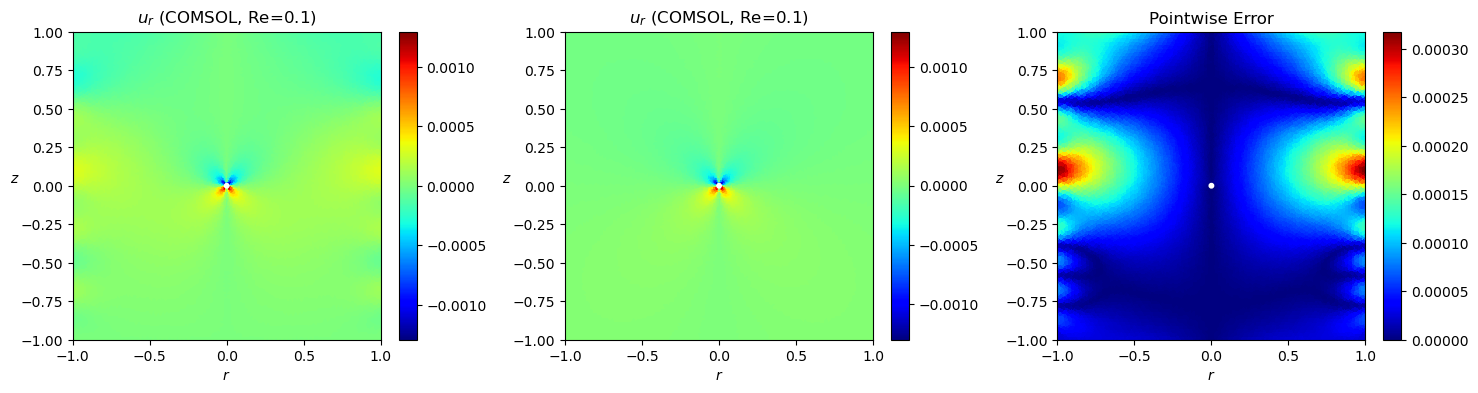

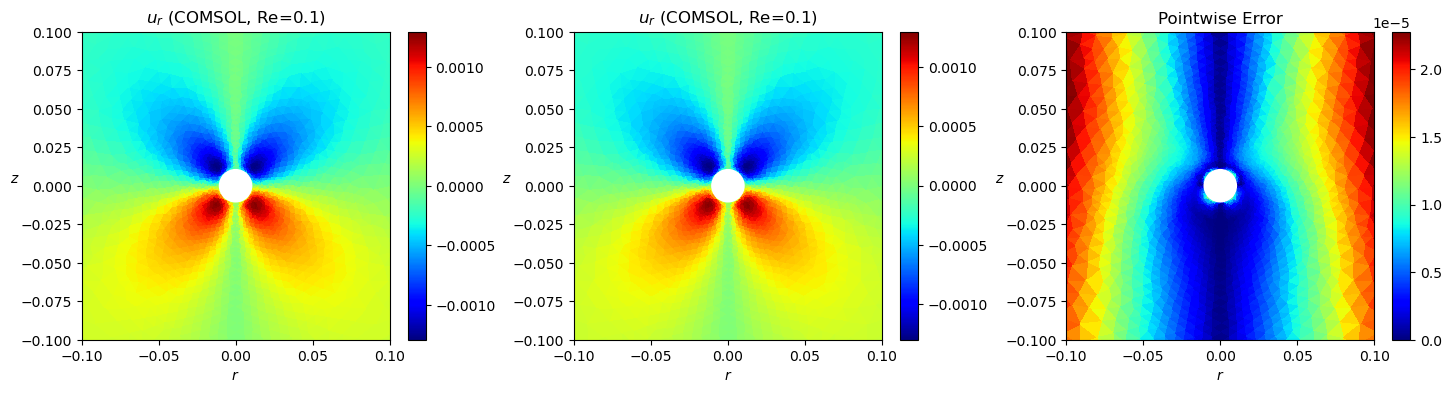

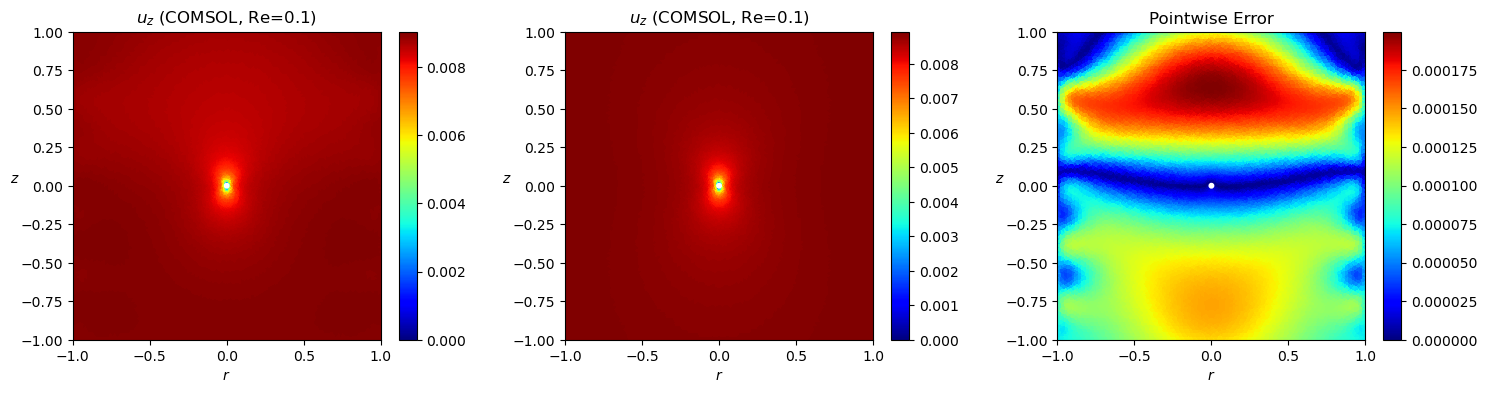

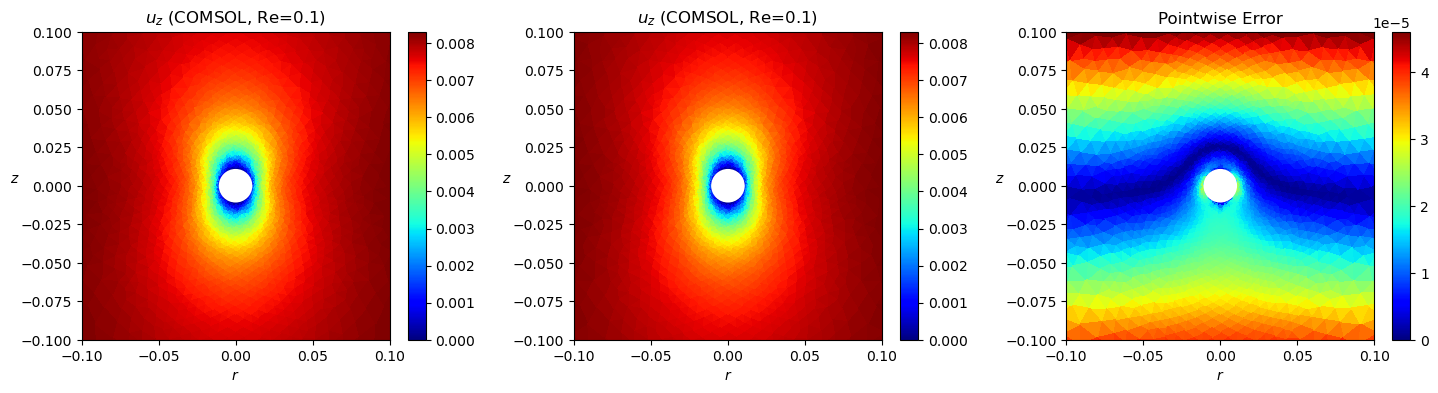

In [23]:
plot_data(r_full, z_full, u_r_c_full, u_r_t_full, component="$u_r$", cmap="jet", lims=1.0, Re=Re)
plot_data(r_full, z_full, u_r_c_full, u_r_t_full, component="$u_r$", cmap="jet", lims=0.1, Re=Re)

plot_data(r_full, z_full, u_z_c_full, u_z_t_full, component="$u_z$", cmap="jet", lims=1.0, Re=Re)
plot_data(r_full, z_full, u_z_c_full, u_z_t_full, component="$u_z$", cmap="jet", lims=0.1, Re=Re)

## Re = 1

In [25]:
r, z, R, theta, v_r_comsol, v_theta_comsol, u_r_comsol, u_z_comsol, U, p_comsol, v_inf, Re, F_t_comsol, F_n_comsol = get_data(direct+"./re_1/", Re=1)

In [26]:
F_t_comsol, F_n_comsol

(0.028952582284192174, 0.06559234755586757)

In [27]:
r_full, z_full, u_r_c_full, u_z_c_full, p_c_full = get_full(r, z, u_r_comsol, u_z_comsol, p_comsol)

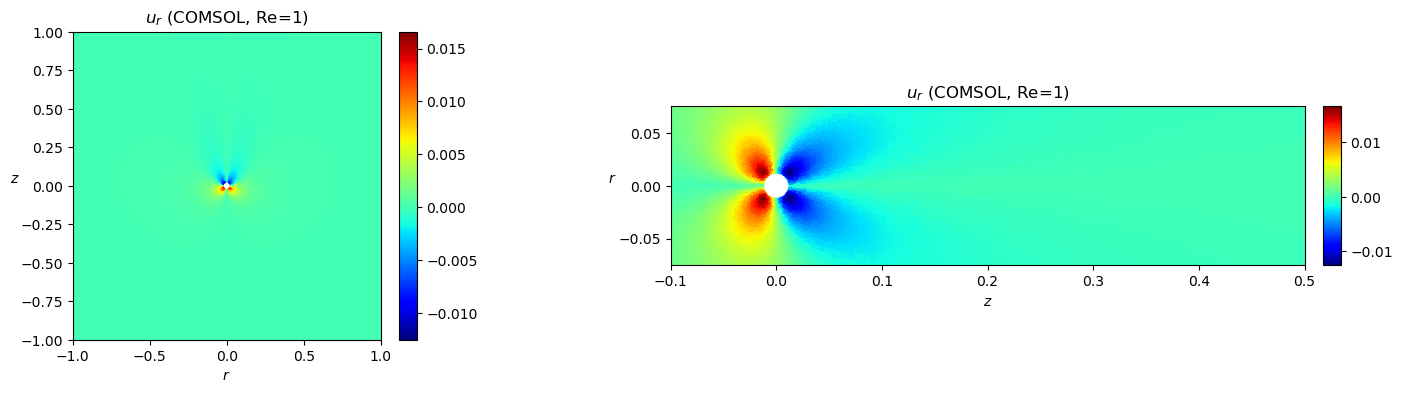

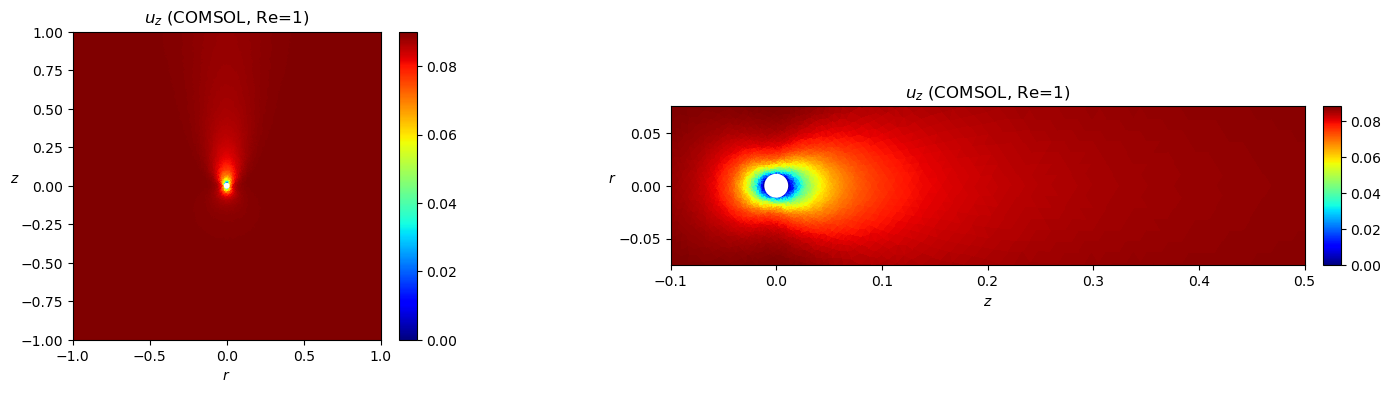

In [28]:
plot_data(r_full, z_full, u_r_c_full, component="$u_r$", cmap="jet", alt_lims=((-.075,.075),(-0.1,0.5)), Re=Re)
plot_data(r_full, z_full, u_z_c_full, component="$u_z$", cmap="jet", alt_lims=((-.075,.075),(-0.1,0.5)), Re=Re)

# Re = 10

In [30]:
r, z, R, theta, v_r_comsol, v_theta_comsol, u_r_comsol, u_z_comsol, U, p_comsol, v_inf, Re, F_t_comsol, F_n_comsol = get_data(direct+"./re_10/", Re=10)

In [31]:
F_t_comsol, F_n_comsol

(0.44240059629656897, 0.28917009711235525)

In [32]:
r_full, z_full, u_r_c_full, u_z_c_full, p_c_full = get_full(r, z, u_r_comsol, u_z_comsol, p_comsol)

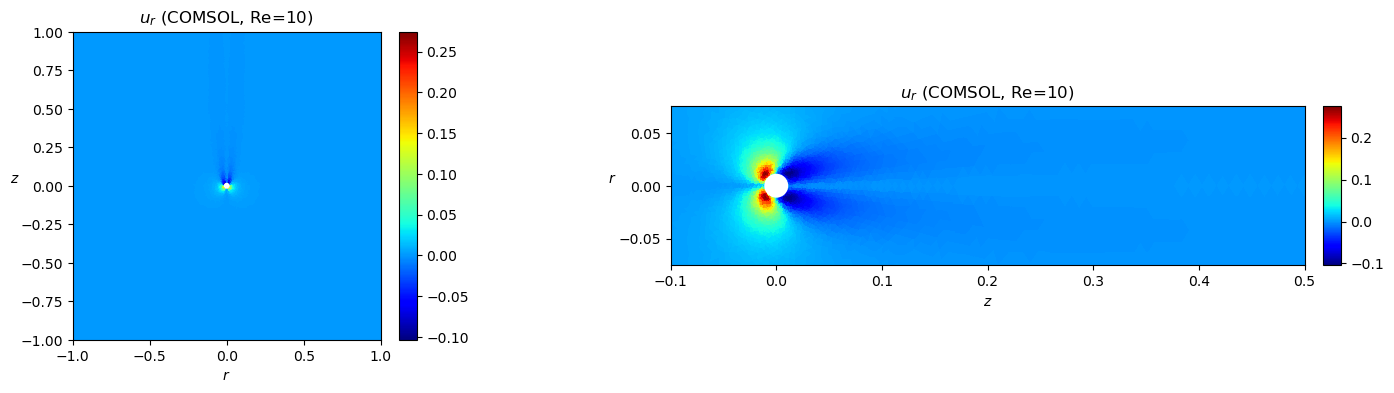

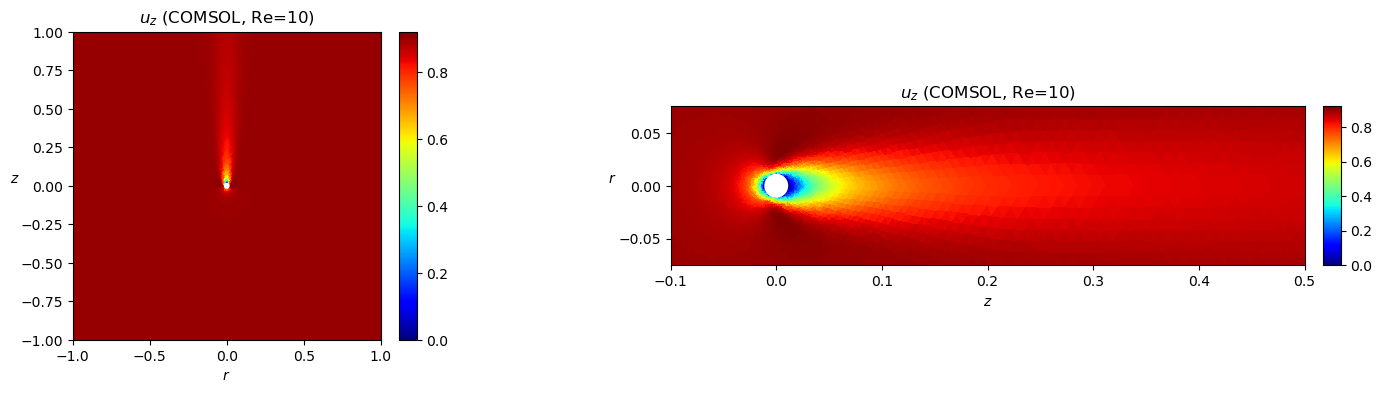

In [33]:
plot_data(r_full, z_full, u_r_c_full, component="$u_r$", cmap="jet", alt_lims=((-.075,.075),(-0.1,0.5)), Re=Re)
plot_data(r_full, z_full, u_z_c_full, component="$u_z$", cmap="jet", alt_lims=((-.075,.075),(-0.1,0.5)), Re=Re)

# Re = 100

In [35]:
r, z, R, theta, v_r_comsol, v_theta_comsol, u_r_comsol, u_z_comsol, U, p_comsol, v_inf, Re, F_t_comsol, F_n_comsol = get_data(direct+"./re_100/", Re=100)

In [36]:
F_t_comsol, F_n_comsol

(9.145798336214623, 8.200505892526675)

In [37]:
r_full, z_full, u_r_c_full, u_z_c_full, p_c_full = get_full(r, z, u_r_comsol, u_z_comsol, p_comsol)

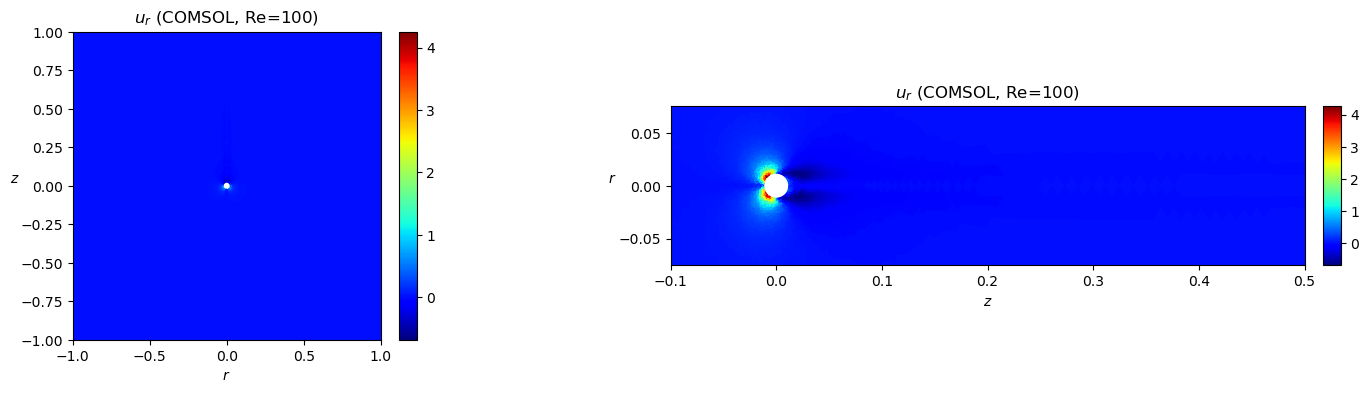

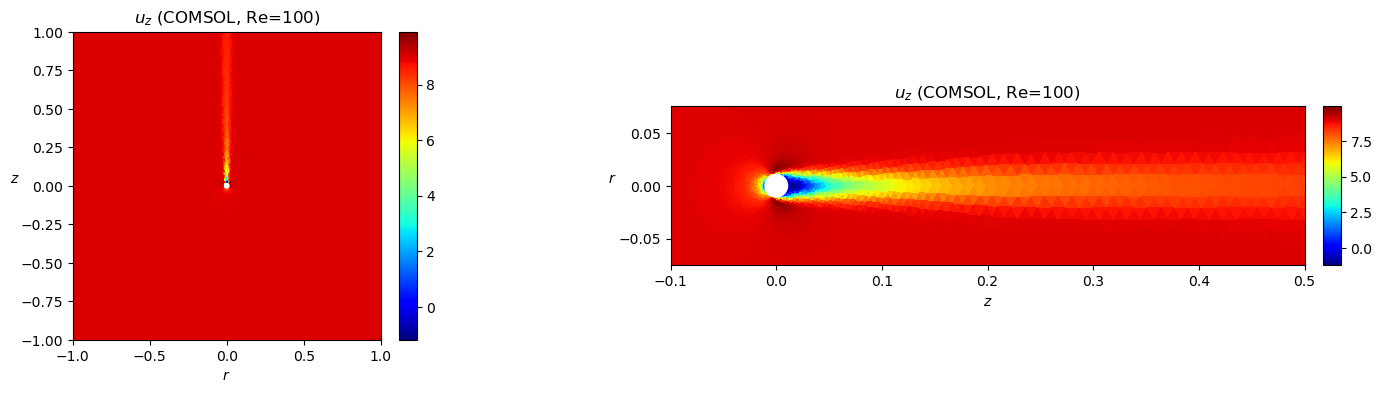

In [38]:
plot_data(r_full, z_full, u_r_c_full, component="$u_r$", cmap="jet", alt_lims=((-.075,.075),(-0.1,0.5)), Re=Re)
plot_data(r_full, z_full, u_z_c_full, component="$u_z$", cmap="jet", alt_lims=((-.075,.075),(-0.1,0.5)), Re=Re)